<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sound classification with convolutional networks and fast ai
This is an example of how easy it is to get great results quickly with the new fastai library.

We will attempt a 10 class sound classification problem: [urbansound8k](https://urbansounddataset.weebly.com/urbansound8k.html)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music.

We will convert the audio files to spectrogram images and then classify with fastai's vision learner.

# Download and extract audio data

In [1]:
import random 
import os
import numpy as np
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True

SEED = 1667
seed_everything(SEED)

In [2]:
import pandas as pd

In [3]:
DATASET = "Data_expanded.zip"
DESCRIPTOR_FILE = "building_floor_recognition_expanded.csv"

In [4]:
# delete data if already existing
!rm -r Data/
!rm {DESCRIPTOR_FILE}

# Data_chunked_{chunk_size}, building_floor_recognition_chunked_{chunk_size},Data_chunked_{chunk_size}.zip

# download from remote repo
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/{DATASET}
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/{DESCRIPTOR_FILE}
!unzip -o -qqq {DATASET} 

# delete useless artifacts
!rm {DATASET}

rm: cannot remove 'Data/': No such file or directory
rm: cannot remove 'building_floor_recognition_expanded.csv': No such file or directory
--2022-08-02 15:32:25--  https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_expanded.zip
Resolving huggingface.co (huggingface.co)... 34.231.117.252, 52.2.34.29, 2600:1f18:147f:e850:d57d:d46a:df34:61ee, ...
Connecting to huggingface.co (huggingface.co)|34.231.117.252|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/31856de779dedd2a845724182c277a1b96faec50533c876c45a8aa48949f4e08?response-content-disposition=attachment%3B%20filename%3D%22Data_expanded.zip%22 [following]
--2022-08-02 15:32:25--  https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/31856de779dedd2a845724182c277a1b96faec50533c876c45a8aa48949f4e08?response-co

In [5]:
# reading descriptor document (a .csv file describing audio samples in dataset)
raw_dataset = pd.read_csv(DESCRIPTOR_FILE)
dataset = raw_dataset.copy()
#dataset.floor.replace({1:0,5:1},inplace=True)
dataset.head(10)

,samples,floor,building
0,R+5/TIS06/Esquissons_TIS06S01.mp3.wav_3.wav,5,TIS06
1,R+5/FV14/Esquissons_FV14.mp3.wav_22.wav,5,FV14
2,R+1/EC02/Esquissons_EC02.mp3.wav_14.wav,1,EC02
3,R+1/CB09/Esquissons_CB09S01.mp3.wav_6.wav,1,CB09
4,R+1/VM02/Esquissons_VM02.mp3.wav_15.wav,1,VM02
5,R+5/VM04/Esquissons_VM04S01.mp3.wav_0.wav,5,VM04
6,R+1/EC02/Esquissons_EC02.mp3.wav_19.wav,1,EC02
7,R+5/FV12/Esquissons_FV12_2.mp3.wav_19.wav,5,FV12
8,R+5/FV11/Esquissons_FV11 copie.mp3.wav_25.wav,5,FV11
9,R+5/CB06/Esquissons_CB6S01.mp3.wav_18.wav,5,CB06


In [6]:
!ls Data/

R+1  R+3  R+5


The folder structure contains 10 predefined validation folds.
According to the creators of the data set, you should evaluate with the provided folds and not reshuffle.

"Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores
We have seen reports that only provide results for a single train/test split, e.g. train on folds 1-9, test on fold 10 and report a single accuracy score. We strongly advise against this. Instead, perform 10-fold cross validation using the provided folds and report the average score.

Why?
Not all the splits are as "easy". That is, models tend to obtain much higher scores when trained on folds 1-9 and tested on fold 10, compared to (e.g.) training on folds 2-10 and testing on fold 1. For this reason, it is important to evaluate your model on each of the 10 splits and report the average accuracy.
Again, your results will NOT be comparable to previous results in the literature."

Let's listen to a sound

In [7]:
# import IPython
# IPython.display.Audio("UrbanSound8K/audio/fold1/26270-9-0-35.wav")

All audio samples are 4 seconds long which fits well with our spectrogram method.

# Process the data and create spectrograms

In [8]:
rm -r Data/R+3

In [9]:
labels  = ['R+1','R+5']

In [10]:
!mkdir Data_spec

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from pathlib import Path 
import os
os.chdir("/content")
def create_fold_spectrograms(fold_name,fold_dataset):
    spectrogram_path = Path('Data_spec/')  
    audio_path = Path('/content/Data/')  
    print(f'Processing fold {fold_name}')

    created = set()

    
    audio_files = fold_dataset.samples.values
    labels = fold_dataset.floor.values
    for audio_file,label in tqdm(zip(audio_files,labels)):
        #print(audio_path/audio_file)
        #print(label)
        if label not in created:
          os.mkdir(spectrogram_path/fold_name/('R+'+str(label)))
          created.add(label)
        samples, sample_rate = librosa.load(audio_path/audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold_name/('R+'+str(label))/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [12]:
!rm -r Data_spec
!mkdir Data_spec/

In [13]:
# Testing scheme assuring that no building is in train and test set

test_dataset_ = dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x: x.sample(2)).reset_index(drop=True)[['building','floor']]
test_dataset = pd.merge(dataset,test_dataset_, on = ['building','floor'])
test_dataset.head()
new_dataset = pd.concat([dataset,test_dataset]).drop_duplicates(keep=False)
val_dataset_ = new_dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x: x.sample(1)).reset_index(drop=True)[['building','floor']]
val_dataset = pd.merge(dataset,val_dataset_, on = ['building','floor'])
val_dataset.head()
train_dataset = pd.concat([new_dataset,val_dataset]).drop_duplicates(keep=False)
train_dataset.shape
assert(len(train_dataset)+len(val_dataset)+len(test_dataset)==len(dataset)),"You did something wrong"

In [14]:
folds = {'train':train_dataset,'test':test_dataset,'valid':val_dataset}
for f in folds:
  try:
    os.mkdir('Data_spec/'+f)
  except FileExistsError:
    pass
  create_fold_spectrograms(f,folds[f])

Processing fold train


376it [02:22,  2.63it/s]


Processing fold test


126it [00:49,  2.52it/s]


Processing fold valid


55it [00:16,  3.28it/s]


Create ImageNet style directory structure for each of the folds for easy data loading

In [15]:
train_dataset.head()

,samples,floor,building
0,R+5/TIS06/Esquissons_TIS06S01.mp3.wav_3.wav,5,TIS06
2,R+1/EC02/Esquissons_EC02.mp3.wav_14.wav,1,EC02
3,R+1/CB09/Esquissons_CB09S01.mp3.wav_6.wav,1,CB09
4,R+1/VM02/Esquissons_VM02.mp3.wav_15.wav,1,VM02
6,R+1/EC02/Esquissons_EC02.mp3.wav_19.wav,1,EC02


In [16]:
# import os
# import glob
# import shutil
# from pathlib import Path  
# data_path = Path('Data/') 
# spectrogram_path = Path('Data_spec/')  
# def create_fold_directory(fold):
#     png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
#     os.mkdir(data_path/fold)
#     os.mkdir(data_path/fold/'train')
#     os.mkdir(data_path/fold/'valid')
#     for label in labels:
#         os.mkdir(data_path/fold/'train'/label)
#         os.mkdir(data_path/fold/'valid'/label)
     
#     for file in png_files:
#         label = file.as_posix().split('-')[1]
#         shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
#     for i in range(1, 11):       
#         if str(i) == fold:
#             continue
#         png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
#         for file in png_files:
#             label = file.as_posix().split('-')[1]
#             shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name) 

In [17]:
# for i in range(1, 11):
#     create_fold_directory(str(i))

First let's take a look at some of the data

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [19]:
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])

In [20]:
data_directory = Path('Data_spec/')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataLoaders.from_folder(data_directory, ds_tfms=[], size=32)
#data.normalize(imagenet_stats)    

In [21]:
help(data.show_batch)

Help on method show_batch in module fastai.data.core:

show_batch(b=None, max_n: 'int' = 9, ctxs=None, show: 'bool' = True, unique: 'bool' = False, **kwargs) method of fastai.data.core.TfmdDL instance
    Show `b` (defaults to `one_batch`), a list of lists of pipeline outputs (i.e. output of a `DataLoader`)



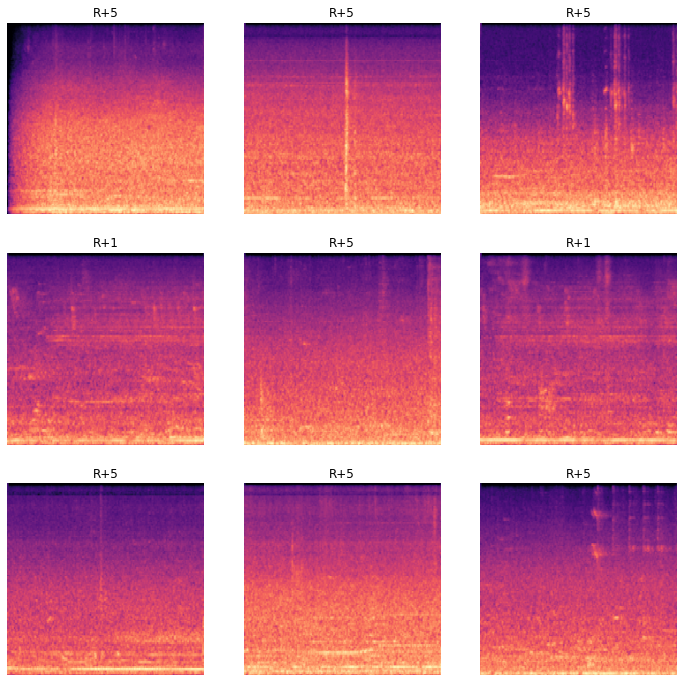

In [22]:
data.show_batch(figsize=(12,12))

In [28]:
path = 'Data_spec/'
data_directory = Path(path)
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
data = ImageDataLoaders.from_folder(data_directory, ds_tfms=batch_tfms, size=16)

In [32]:
#data.normalize(imagenet_stats)
learner = vision_learner(data, arch=resnet34, metrics=error_rate,)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
learner.dls = data

SuggestedLRs(valley=0.0010000000474974513)

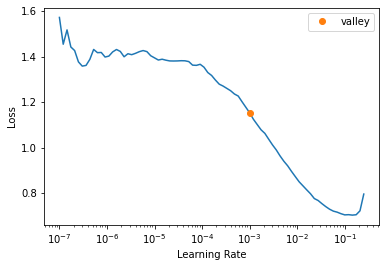

In [35]:
learner.lr_find()


In [41]:
lr = 1e-3
learner = vision_learner(data, arch=resnet34, metrics=error_rate,)
learner.freeze()
learner.fit_one_cycle(5,slice(lr))
learner.unfreeze()
learner.fit_one_cycle(10,slice(1e-3))
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-2))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.280839,0.810283,0.400000,00:02
1,0.919652,1.788193,0.509091,00:02
2,0.707175,2.029724,0.490909,00:02
3,0.580017,1.771821,0.472727,00:02
4,0.493515,1.449270,0.436364,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.270888,1.184037,0.400000,00:02
1,0.192977,0.919608,0.345455,00:02
2,0.146590,0.772190,0.254545,00:02
3,0.115628,1.660302,0.400000,00:02
4,0.100014,1.011768,0.272727,00:02
5,0.084023,0.657830,0.200000,00:02
6,0.069060,0.788960,0.254545,00:02
7,0.058903,0.801989,0.254545,00:02
8,0.050562,0.775513,0.254545,00:02
9,0.044976,0.836551,0.254545,00:02


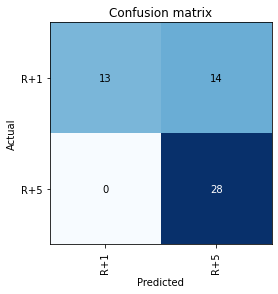

In [43]:
interpret = ClassificationInterpretation.from_learner(learner)
interpret.plot_confusion_matrix()

In [46]:
data.valid

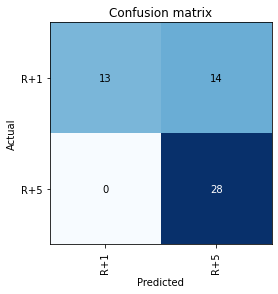

In [47]:
interpret = ClassificationInterpretation.from_learner(learner,dl=data.valid)
interpret.plot_confusion_matrix()

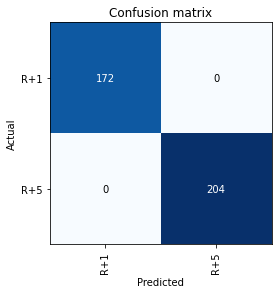

In [48]:
interpret = ClassificationInterpretation.from_learner(learner,dl=data.train)
interpret.plot_confusion_matrix()

In [ ]:
# Testing on test
path = 'Data_spec/'
data_directory = Path(path)
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
data_test = ImageDataLoaders.from_folder(data_directory, ds_tfms=batch_tfms, size=16, train = "train",valid="test")

In [49]:
interpret = ClassificationInterpretation.from_learner(learner,dl=data_test.valid)
interpret.plot_confusion_matrix()

AttributeError: ignored

In [ ]:
!untar Stag